---
title: "Practice Activity – 8.2"
author: "Shiqi Wu"
format:
  html:
    self-contained: true      
    toc: true
    code-fold: false
jupyter: python3
execute:
  echo: true
  warning: false
  message: false
---

**Repository:** [GSB-S544-01](https://github.com/shiqiwu212/GSB-S544-01/tree/cd65c1f0e328a787f0c7de4f4cd1265ad5d0e7a0/Week%208/Practice%20Activities/Practice%20Activity%208.2)

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `species` using the other variables in the dataset.

**Dummify** all variables that require this.

In [45]:
# Code Here
# Set Up
import numpy as np
import pandas as pd
from palmerpenguins import load_penguins

In [46]:
#Load Data
cols_needed = ["species","island","bill_length_mm","bill_depth_mm",
               "flipper_length_mm","body_mass_g","sex","year"]
penguins = load_penguins()

df = penguins.dropna(subset=cols_needed)

In [47]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [48]:
X_all = df.drop(columns=["species"])
cat_cols = X_all.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
print("Categorical columns to dummify:", cat_cols)
print("Numeric columns:", num_cols)

Categorical columns to dummify: ['island', 'sex']
Numeric columns: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']


Let's use the other variables to predict `species`. Prepare your data and fit the following models on the entire dataset:

* Two kNN models (for different values of K)
* Two decision tree models (for different complexities of trees)

Compute the following, for each of your models, on test data. Keep in mind that you may need to stratify your creation of the training and test data.

* Confusion matrix
* Overall Accuracy
* Precision, Recall, AUC, and F1-score for each species

Create one ROC plot for the species of your choice.

In [49]:
# Code Here
# Source: Ch.16 train/test split (stratify) + ColumnTransformer for OHE
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder

In [50]:
# Target & predictors
y = df["species"]
X = df.drop(columns=["species"])

In [51]:
# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y)

In [52]:
# One-hot for categoricals, passthrough numerics
ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"),
         make_column_selector(dtype_include=["object","category"])),
        ("num", "passthrough",
         make_column_selector(dtype_include=np.number)),
    ],
    remainder="drop"
)

In [53]:
labels = sorted(y.unique())  
labels

['Adelie', 'Chinstrap', 'Gentoo']

In [54]:
# Source: Ch.16 kNN classification (two K values)
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

In [55]:
knn3 = Pipeline([("prep", ct), ("clf", KNeighborsClassifier(n_neighbors=3))])
knn7 = Pipeline([("prep", ct), ("clf", KNeighborsClassifier(n_neighbors=7))])

knn3.fit(X_train, y_train)
knn7.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
# Source: Ch.16 decision trees (different complexities)
from sklearn.tree import DecisionTreeClassifier

tree_d3 = Pipeline([("prep", ct), ("clf", DecisionTreeClassifier(max_depth=3, random_state=1))])
tree_d6 = Pipeline([("prep", ct), ("clf", DecisionTreeClassifier(max_depth=6, random_state=1))])

tree_d3.fit(X_train, y_train)
tree_d6.fit(X_train, y_train)

,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [57]:
# Source: Ch.16.5 evaluation: confusion matrix, accuracy, PRF1; one-vs-rest AUC per class
# AI help with this step, cause I don't know how to do.
from sklearn.metrics import (
    confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score
)

def evaluate_model(model, name):
    # predictions and probabilities on the test set
    y_pred = model.predict(X_test)
    proba = model.predict_proba(X_test)

    # overall accuracy
    acc = accuracy_score(y_test, y_pred)

    # per-class precision/recall/f1
    prec, rec, f1, support = precision_recall_fscore_support(
        y_test, y_pred, labels=labels, zero_division=0
    )
    prf1 = pd.DataFrame(
        {"precision":prec, "recall":rec, "f1":f1, "support":support},
        index=pd.Index(labels, name="class")
    )

    # per-class ROC AUC (one-vs-rest)
    # match class order between model.classes_ and our labels
    class_order = list(model.named_steps["clf"].classes_)
    auc_per_class = {}
    for lab in labels:
        j = class_order.index(lab)
        auc_per_class[lab] = roc_auc_score(
            (y_test==lab).astype(int), proba[:, j]
        )
    auc_series = pd.Series(auc_per_class, name="AUC (OvR)")

    # confusion matrix
    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred, labels=labels),
        index=pd.Index(labels, name="Actual"),
        columns=pd.Index(labels, name="Predicted")
    )

    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    display(prf1)
    display(auc_series)
    display(cm)

In [58]:
# Evaluate all four models
evaluate_model(knn3,  "kNN (k=3)")
evaluate_model(knn7,  "kNN (k=7)")
evaluate_model(tree_d3,"Decision Tree (max_depth=3)")
evaluate_model(tree_d6,"Decision Tree (max_depth=6)")


=== kNN (k=3) ===
Accuracy: 0.8333333333333334


,precision,recall,f1,support
class,,,,
Adelie,0.780488,0.864865,0.820513,37
Chinstrap,0.615385,0.470588,0.533333,17
Gentoo,1.000000,1.000000,1.000000,30


Adelie       0.895630
Chinstrap    0.777436
Gentoo       1.000000
Name: AUC (OvR), dtype: float64

Predicted,Adelie,Chinstrap,Gentoo
Actual,,,
Adelie,32,5,0
Chinstrap,9,8,0
Gentoo,0,0,30



=== kNN (k=7) ===
Accuracy: 0.8452380952380952


,precision,recall,f1,support
class,,,,
Adelie,0.770833,1.000000,0.870588,37
Chinstrap,1.000000,0.294118,0.454545,17
Gentoo,0.935484,0.966667,0.950820,30


Adelie       0.901093
Chinstrap    0.783143
Gentoo       0.998457
Name: AUC (OvR), dtype: float64

Predicted,Adelie,Chinstrap,Gentoo
Actual,,,
Adelie,37,0,0
Chinstrap,10,5,2
Gentoo,1,0,29



=== Decision Tree (max_depth=3) ===
Accuracy: 0.9761904761904762


,precision,recall,f1,support
class,,,,
Adelie,0.948718,1.000000,0.973684,37
Chinstrap,1.000000,0.882353,0.937500,17
Gentoo,1.000000,1.000000,1.000000,30


Adelie       1.0
Chinstrap    1.0
Gentoo       1.0
Name: AUC (OvR), dtype: float64

Predicted,Adelie,Chinstrap,Gentoo
Actual,,,
Adelie,37,0,0
Chinstrap,2,15,0
Gentoo,0,0,30



=== Decision Tree (max_depth=6) ===
Accuracy: 1.0


,precision,recall,f1,support
class,,,,
Adelie,1.0,1.0,1.0,37
Chinstrap,1.0,1.0,1.0,17
Gentoo,1.0,1.0,1.0,30


Adelie       1.0
Chinstrap    1.0
Gentoo       1.0
Name: AUC (OvR), dtype: float64

Predicted,Adelie,Chinstrap,Gentoo
Actual,,,
Adelie,37,0,0
Chinstrap,0,17,0
Gentoo,0,0,30


In [59]:
# Source: Ch.16 ROC curve for a chosen class 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [60]:
chosen_species = "Adelie"      
model_for_roc = knn7 

In [61]:
proba   = model_for_roc.predict_proba(X_test)
classes = list(model_for_roc.named_steps["clf"].classes_)
j = classes.index(chosen_species)

In [62]:
# one-vs-rest labels & scores
y_true_bin = (y_test == chosen_species).astype(int)
y_score    = proba[:, j]

In [63]:
# ROC + AUC
fpr, tpr, _ = roc_curve(y_true_bin, y_score)
roc_auc = auc(fpr, tpr)

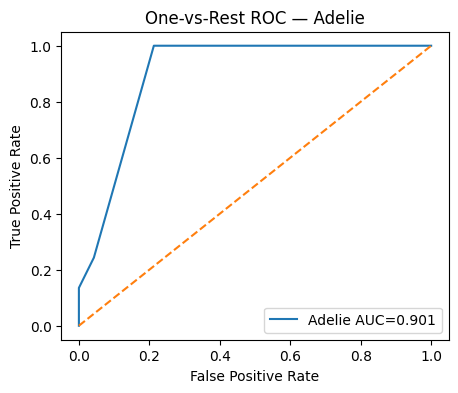

In [64]:
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"{chosen_species} AUC={roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"One-vs-Rest ROC — {chosen_species}")
plt.legend(); plt.show()